In [3]:
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
import cv2
from cv2 import aruco
import matplotlib.pyplot as plt
import pandas as pd
import os
import polars as pl
import toml
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
from support.pd_support import *

from datetime import datetime
from support.pd_support import *
from support.ar_calculations import *

from scipy.signal import savgol_filter
from scipy import integrate
from scipy import stats
import toml

import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from tqdm import tqdm
import seaborn as sns

pio.renderers.default = "vscode"

In [4]:
_pth = toml.load('DATA_PATH.toml')['data_path']['directory']
_pth = os.path.dirname(_pth)
_parent_folder = "paper"
_calib_folder_name = "calibration_00"

_base_pth = os.path.join(_pth,"recorded_data",_parent_folder)
# _folder_list = os.listdir(_base_pth)[10:15] # forward
_folder_list = os.listdir(_base_pth)[17:17+9] # sideways


_webcam_calib_folder = os.path.join(_pth,"recorded_data",_parent_folder,_calib_folder_name)
_webcam_calib_folder = os.path.join(_webcam_calib_folder)
_webcam_calib_pth = os.path.join( _webcam_calib_folder, "webcam_calibration.msgpack")

with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]

ar_lframe_pth = os.path.join(_webcam_calib_folder, "jr3_rotmat.msgpack")
with open(ar_lframe_pth, "rb") as f:
    ar_lframe = mp.Unpacker(f, object_hook=mpn.decode)
    _ar_lframe_rot = next(ar_lframe)
    _ar_lframe_org = next(ar_lframe)

MOCAP data

In [5]:
m1 = get_rb_marker_name(1)
m4 = get_rb_marker_name(2)
m3 = get_rb_marker_name(3)
m5 = get_rb_marker_name(6)

Getting Sync pulse from Teensy

In [6]:
def estimatePoseSingleMarkers(corners, marker_size, mtx, distortion):

    marker_points = np.array([[-marker_size / 2, marker_size / 2, 0],
                              [marker_size / 2, marker_size / 2, 0],
                              [marker_size / 2, -marker_size / 2, 0],
                              [-marker_size / 2, -marker_size / 2, 0]], dtype=np.float32)
    trash = []
    rvecs = []
    tvecs = []
    for c in corners:
        nada, R, t = cv2.solvePnP(marker_points, c, mtx, distortion, True, flags= cv2.SOLVEPNP_ITERATIVE)
        
        if not (R is None or t is None):
            R = np.array(R).reshape(1, 3).tolist()
            t = np.array(t).reshape(1, 3).tolist()
        
        rvecs.append(R)
        tvecs.append(t)
    return rvecs, tvecs

In [7]:
results = {'ar_df':[], 'ar_dt':[], 'mc_xdf':[], 'mc_dt':[], 'time_offset':[], 'vel_bins':[], 'mc_df':[], 'mc_xdf':[], 'folder_name':[]}
for _folder_name in _folder_list:
    _teensy_df = pl.read_csv(os.path.join(_base_pth,_folder_name,"imu01.csv"))
    _teensy_df = _teensy_df.with_columns(pl.col("mz\r").str.replace("\r","").cast(pl.Float64).alias("mz"))
    t_time = _teensy_df["rust_time"].to_numpy()
    t_time = [datetime.fromtimestamp(t) for t in t_time]
    # t_time = [datetime.strftime(t) for t in t_time]
    teensy_df = pl.DataFrame({"time":t_time,"sync":_teensy_df["sync"]})

    for idx, i in enumerate(teensy_df['sync']):
        if i == 1:
            break
    teensy_start_time = teensy_df['time'][idx]
    
    # Aruco parameters
    
    ARUCO_PARAMETERS = aruco.DetectorParameters()
    ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_ARUCO_MIP_36H12)
    detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
    markerLength = int(_folder_name.split("_")[2])/100
    markerSeperation = 0.01

    board = aruco.GridBoard(
            size= [1,1],
            markerLength=markerLength,
            markerSeparation=markerSeperation,
            dictionary=ARUCO_DICT)
    
    
    # timestamp
    ts = []
    ts_pth = os.path.join(_base_pth, _folder_name, "webcam_timestamp.msgpack")
    ts_file = open(ts_pth, "rb")
    ts_unpacker = mp.Unpacker(ts_file, object_hook=mpn.decode)
    for ts_data in ts_unpacker:
        ts.append(ts_data)
        
    # reading video
    _video_pth = os.path.join(_base_pth,_folder_name,"webcam_color.msgpack")
    _video_file = open(_video_pth, "rb")
    _video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)

    default_ids = [12, 88, 89]

    data = {"frame_id":[],"marker_ids":[], "corners":[], "tvec":[], "rvec":[]}

    counter = 0

    for _frame in tqdm(_video_data):

        shape = _frame.shape
        gray = cv2.cvtColor(_frame, cv2.COLOR_BGR2GRAY)
        corners, ids, rejectedpoints = detector.detectMarkers(_frame)
        # refine corners
        corners, ids, rejectedpoints,_ = detector.refineDetectedMarkers(image=_frame,board=board ,detectedCorners=corners, detectedIds=ids, rejectedCorners=rejectedpoints, cameraMatrix=_webcam_cam_mat, distCoeffs=_webcam_dist)
        rvec, tvec  = estimatePoseSingleMarkers(corners=corners, marker_size=markerLength, mtx=_webcam_cam_mat, distortion=_webcam_dist)

        if ids is None:
            data["frame_id"].append(counter)
            data["marker_ids"].append(None)
            data["corners"].append(None)
            data["tvec"].append(None)
            data["rvec"].append(None)

        if ids is not None:
            data["frame_id"].append(counter)
            data["marker_ids"].append(ids)
            data["corners"].append(corners)
            data["tvec"].append(tvec)
            data["rvec"].append(rvec)

        counter+=1
    _video_file.close()
    
    # coordinates
    
    coordinate = {str(default_ids[0]):{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]},
              str(default_ids[1]):{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]},
              str(default_ids[2]):{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]}}

    doesnt_exist = []
    # default_ids = [100, 49, 80]
    zero_counter = 0
    for i in range(len(data["frame_id"])):
        if data["marker_ids"][i] is not None:
            
            if default_ids[0] not in data["marker_ids"][i]:
                doesnt_exist.append(default_ids[0])
            if default_ids[1] not in data["marker_ids"][i]:
                doesnt_exist.append(default_ids[1])
            if default_ids[2] not in data["marker_ids"][i]:
                doesnt_exist.append(default_ids[2])
                
            _zero_counter = 0            
            for j, _m in enumerate(data["marker_ids"][i]):
                    
                if _m in default_ids:
                    coordinate[str(_m[0])]["x"].append(data["tvec"][i][j][0][0])
                    coordinate[str(_m[0])]["y"].append(data["tvec"][i][j][0][1])
                    coordinate[str(_m[0])]["z"].append(data["tvec"][i][j][0][2])
                    coordinate[str(_m[0])]["rx"].append(data["rvec"][i][j][0][0])
                    coordinate[str(_m[0])]["ry"].append(data["rvec"][i][j][0][1])
                    coordinate[str(_m[0])]["rz"].append(data["rvec"][i][j][0][2])

            for k in doesnt_exist:
                coordinate[str(k)]["x"].append(np.nan)
                coordinate[str(k)]["y"].append(np.nan)
                coordinate[str(k)]["z"].append(np.nan)
                coordinate[str(k)]["rx"].append(np.nan)
                coordinate[str(k)]["ry"].append(np.nan)
                coordinate[str(k)]["rz"].append(np.nan)
                
        else:
            for _k in default_ids:
                coordinate[str(_k)]["x"].append(np.nan)
                coordinate[str(_k)]["y"].append(np.nan)
                coordinate[str(_k)]["z"].append(np.nan)
                coordinate[str(_k)]["rx"].append(np.nan)
                coordinate[str(_k)]["ry"].append(np.nan)
                coordinate[str(_k)]["rz"].append(np.nan)
                
        doesnt_exist.clear()
        
        
    # creating dataframe
    
    if type(ts[0]) != datetime:
    # convert epoch to datetime
        ts = [datetime.fromtimestamp(t) for t in ts]
    translation_correction = np.array([0.045, -0.05, 0.045]).reshape(3, 1)

    ar_df = pl.DataFrame({"time":ts,"x":coordinate[str(default_ids[2])]["x"][:len(ts)], "y":coordinate[str(default_ids[2])]["y"][:len(ts)], "z":coordinate[str(default_ids[2])]["z"][:len(ts)], "rx":coordinate[str(default_ids[2])]["rx"][:len(ts)], "ry":coordinate[str(default_ids[2])]["ry"][:len(ts)], "rz":coordinate[str(default_ids[2])]["rz"][:len(ts)]})

    rvec = coordinate[str(default_ids[2])]["rx"][0], coordinate[str(default_ids[2])]["ry"][0], coordinate[str(default_ids[2])]["rz"][0]

    ar_rotmat = cv2.Rodrigues(rvec)[0]

    tar = ar_rotmat.T @ (ar_df[['x', 'y', 'z']].to_numpy().T - ar_df[['x', 'y', 'z']][0].to_numpy().T)
    _ar_df = pl.DataFrame({"time":ts,"x":tar[0], "y":tar[1], "z":tar[2], "rx":coordinate[str(default_ids[2])]["rx"][:len(ts)], "ry":coordinate[str(default_ids[2])]["ry"][:len(ts)], "rz":coordinate[str(default_ids[2])]["rz"][:len(ts)]})
    
    print(len(coordinate[str(default_ids[0])]["y"]), len(coordinate[str(default_ids[1])]["y"]), len(coordinate[str(default_ids[2])]["z"]))
    
    _mocap_pth = os.path.join(os.path.dirname(os.path.dirname(_video_pth)),_folder_name.split('_')[0], f"{_folder_name}.csv")
    _mocap_df, st_time = read_rigid_body_csv(_mocap_pth)
    _mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")
    _mocap_df = pl.from_pandas(_mocap_df)

    cumulative = _mocap_df[[m1['x'], m1['y'], m1['z']]].to_numpy().T + _mocap_df[[m4['x'], m4['y'], m4['z']]].to_numpy().T + _mocap_df[[m3['x'], m3['y'], m3['z']]].to_numpy().T + _mocap_df[[m5['x'], m5['y'], m5['z']]].to_numpy().T
    cumulative = cumulative/4

    _m_df = pl.DataFrame({"time":_mocap_df["time"], "x":cumulative[0], "y":cumulative[1], "z":cumulative[2]})
    
    
    _mc_org = _mocap_df[[m3['x'], m3['y'], m3['z']]][0].to_numpy().T
    _mc_xvec = _mocap_df[[m5['x'], m5['y'], m5['z']]][0].to_numpy().T
    _mc_yvec = _mocap_df[[m1['x'], m1['y'], m1['z']]][0].to_numpy().T

    _mc_rotmat = calculate_rotmat_from_xyo(_mc_xvec, _mc_yvec, _mc_org)

    tmc = _mc_rotmat.T @ (_m_df[['x', 'y', 'z']].to_numpy().T - _m_df[['x', 'y', 'z']][0].to_numpy().T)
    _mc_df = pl.DataFrame({"time":_mocap_df["time"], "x":tmc[0], "y":tmc[1], "z":tmc[2]})
    
    # velocity_cuts = np.nanmax(abs(_mc_df['x'].diff()/0.01))/12
    velocity_cuts = 0.6/12
    _vel_bins = []
    for i in range(12):
        _vel_bins.append((i)*velocity_cuts)
    
    
    bin_idx = np.digitize(abs(_mc_df['x'].diff()/0.01), bins=_vel_bins, right=True)
    bin_df = pl.Series("bin",bin_idx)
    _mc_df.insert_at_idx(4,bin_df)
    _mc_df.group_by("bin", maintain_order=True).count()
    
    _time_offset = teensy_df['time'][idx] - ar_df['time'][0]

    # interpolate teensy data to match aruco data

    _temp_df = ar_df.to_pandas()
    clip_idx = _temp_df['time'].sub(teensy_df['time'][idx]).abs().idxmin()

    _ar_df_test = ar_df[clip_idx:]

    _data_time_offset = _ar_df_test['time'][0] - _mocap_df['time'][0]
    _ar_df_test = _ar_df_test.with_columns([(pl.col('time') - _data_time_offset).alias('time')])
    _ar_df = _ar_df_test
    
    ar_time = _ar_df['time'].dt.epoch()
    ar_time = (ar_time - ar_time[0])
    ar_time = [timedelta(microseconds=t).total_seconds() for t in ar_time]
    ar_time = np.array(ar_time)

    mc_time = _mocap_df['time'].dt.epoch()
    mc_time = (mc_time - mc_time[0])
    mc_time = [timedelta(microseconds=t).total_seconds() for t in mc_time]
    mc_time = np.array(mc_time)

    ar_del_t = _ar_df['time'].diff().mean()/10**6
    mc_del_t = 0.01
    
    f = interp1d(_mc_df['time'].dt.epoch(), _mc_df['x'], kind='linear', fill_value="extrapolate")  # You can also use 'cubic' or other interpolation methods
    _mc_x = f(_ar_df['time'].dt.epoch())
    _mc_xdf = pl.DataFrame({"time":_ar_df['time'], "x":_mc_x})
    
    bin_idx = np.digitize(abs(_mc_xdf['x'].diff()/ar_del_t), bins=_vel_bins, right=True)
    bin_df = pl.Series("bin",bin_idx)
    _mc_xdf.insert_at_idx(2,bin_df)
    _ar_df.insert_at_idx(len(_ar_df.columns),bin_df)
        
    results['ar_df'].append(_ar_df)
    results['ar_dt'].append(ar_del_t)
    results['mc_xdf'].append(_mc_xdf)
    results['mc_dt'].append(mc_del_t)
    results['time_offset'].append(_time_offset)
    results['vel_bins'].append(_vel_bins)
    results['mc_df'].append(_mc_df)
    results['mc_xdf'].append(_mc_xdf)
    results['folder_name'].append(_folder_name)

1892it [00:24, 77.27it/s] 


1892 1892 1892


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\CMC\\pyprojects\\DeepVision\\recorded_data\\paper\\jr2\\jr2_30_5_forward_rspeed_01.csv'

In [ ]:
histograms = []

In [ ]:
missing_percent_one = []
missing_percent_all = []

for j in range(len(results['ar_df'])):
    
    for i in range(len(results['ar_df'][0].group_by("bin", maintain_order=False).agg(pl.col('x'))['x'])):
        missing_percent_one.append(1 - results['ar_df'][j].group_by("bin", maintain_order=False).agg(pl.col('x'))['x'][i].is_nan().sum()/len(results['ar_df'][j].group_by("bin", maintain_order=False).agg(pl.col('x'))['x'][i]))
    missing_percent_one = np.array(missing_percent_one)*100
    missing_percent_all.append(missing_percent_one)
    missing_percent_one = []
    

In [ ]:
cols = []
for i in np.array(_vel_bins):
    cols.append(f"{i:.2f}")

per_df = pl.DataFrame(np.array(missing_percent_all))
per_df.columns = cols

Text(0, 0.5, 'Percentage of detection (%)')

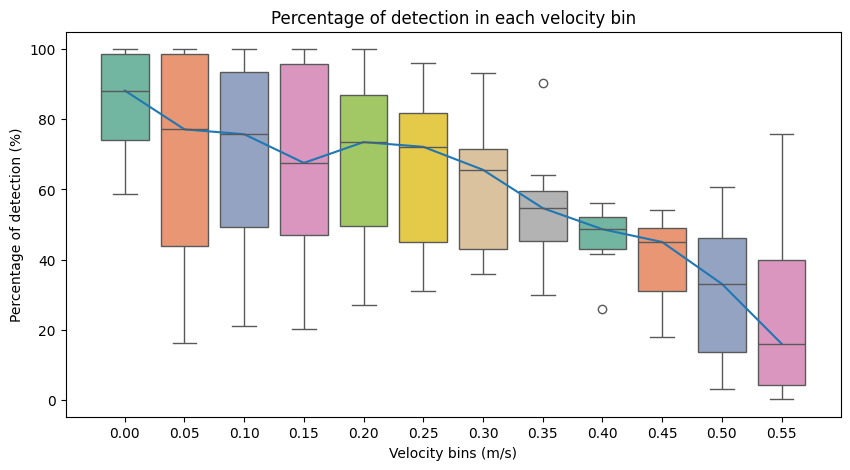

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(data=per_df.to_pandas(), palette="Set2")
sns.lineplot(x=per_df.to_pandas().columns, y=per_df.to_pandas().median())
plt.title("Percentage of detection in each velocity bin")
plt.xlabel("Velocity bins (m/s)")
plt.ylabel("Percentage of detection (%)")

# sns.violinplot(data=per_df.to_pandas(), palette="Set2")

In [ ]:
per_df.write_csv("./data_csv/percentage_detection_ar.csv")